In [1]:
import os
import zipfile
import opendatasets as od
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant #We need to add consant column to calculate VIF
%matplotlib inline

In [3]:
od.download("https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  sebastianchwilczyski


Your Kaggle Key:

  ································


100%|█████████████████████████████████████████████████████████████████████████████| 1.10M/1.10M [00:00<00:00, 8.12MB/s]

In [2]:
def load_csv(folder, file):
    csv_path = os.path.join(folder,file)
    return pd.read_csv(csv_path)

In [3]:
folder = "used-car-dataset-ford-and-mercedes"
file = "audi.csv" # Ill try to predict prices for audi cars
audi_data = load_csv(folder, file)

In [4]:
audi_data["model"] = audi_data["model"].str.replace(" ", "") #there were some leading spaces 
audi_data.head() # to have a glance of what we are working with, price is our target variable

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [5]:
audi_data.info() #to see whether we have some missing value (fortunately not), we have 3 categorical attributes
#(model, transmission, fuelType)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


## Analyzing the "model" attribute
Probably this should be done after dividing set on test and training, but I did it here since some cars types appear only once or twice here

In [6]:
amnt = len(audi_data["model"].value_counts())
print(f"Amount of different values of model attribute: {amnt}") # Here the problem seems to be that we have a lot of difference options
#If we were to oneHotEncodeThem we will need 25 variables, it potentailly can create a mess.
#! In that case it seems like we could use ordinalEncoding. As is is natural that worse models probably should cost less and has lower
#! ordinal value. We could also use Target Encoding and change every model type with it's mean (may lead to overfitting!!).
#! Going further we could based on the means create only few ordinal classes not exactly 26. We can divde models into 3 bins based on
#! their corresponding price means and divide them into 0-standard 1-extra 2-premium.
audi_data["model"].value_counts() # Here the problem

Amount of different values of model attribute: 26


A3     1929
Q3     1417
A4     1381
A1     1347
A5      882
Q5      877
Q2      822
A6      748
Q7      397
TT      336
A7      122
A8      118
Q8       69
RS6      39
RS3      33
RS4      31
RS5      29
R8       28
S3       18
SQ5      16
S4       12
SQ7       8
S8        4
S5        3
A2        1
RS7       1
Name: model, dtype: int64

In [7]:
audi_data[audi_data["model"] == "A2"] # We have only 1 sample of audi A2 and it was horribly cheap as it was quite old.
#But in generall Audi A2 should not be considered as cheap.

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
10158,A2,2003,2490,Manual,100000,Diesel,30,65.7,1.4


In [8]:
#Lets start by grouping dataset based on model, From above what we see that some models, has only a few represents, so probably the mean
# would be rather poorly estimated. We can aply smoothing then. 
global_average = audi_data["price"].mean()
smoothing_param = 10 # Since our dataset is quite small
print(f"Total average:  {global_average}")
audi_data_group_by_model = audi_data.groupby("model")["price"]
sample_means = audi_data_group_by_model.mean()
counts = audi_data_group_by_model.count()
smoothed_mean = (sample_means * counts + smoothing_param * global_average) / (counts + smoothing_param) 
audi_data_means_by_model =pd.concat([counts, sample_means,  smoothed_mean], axis=1, keys=["count", "mean_price",  "smooth_mean"]).sort_values("count")
#Now we observe that cars that vere quite rare in dataset got mean closer to the global_mean. And for these models that we have a lot of samples mean was not affected
audi_data_means_by_model


Total average:  22896.685039370077


,count,mean_price,smooth_mean
model,,,
A2,1,2490.000000,21041.531854
RS7,1,33490.000000,23859.713672
S5,3,15980.000000,21300.526953
S8,4,33807.750000,26014.132171
SQ7,8,49269.000000,34617.713911
S4,12,31248.083333,27451.993200
SQ5,16,31415.812500,28139.225015
S3,18,20379.444444,21278.458943
R8,28,97652.214286,77979.706589


In [9]:
# Know based on that we can create bins with categories. There are a few rule of thumbs about amount of bins but quite often we use sqrt(n)
n = len(audi_data["model"].value_counts())
#This will assign every car to some category
offset = 1 #To try different amount of bins
bins_classic_mean = pd.cut(audi_data_means_by_model["mean_price"], bins=int(math.sqrt(n))+offset,labels = list(range(int(math.sqrt(n))+offset)))
bins_smoothed_mean = pd.cut(audi_data_means_by_model["smooth_mean"], bins=int(math.sqrt(n))+offset,labels = list(range(int(math.sqrt(n))+offset)))
audi_data_means_by_model["mean_mapping"] = bins_classic_mean
audi_data_means_by_model["smothed_mean_mapping"] = bins_smoothed_mean
audi_data_means_by_model #! And assigned classes differ a lot.
# fig, ax = plt.subplots(1,2)
# bins_smoothed_mean.hist(ax=ax[0])
# bins_classic_mean.hist(ax=ax[1])

,count,mean_price,smooth_mean,mean_mapping,smothed_mean_mapping
model,,,,,
A2,1,2490.000000,21041.531854,0,0
RS7,1,33490.000000,23859.713672,1,0
S5,3,15980.000000,21300.526953,0,0
S8,4,33807.750000,26014.132171,1,1
SQ7,8,49269.000000,34617.713911,2,1
S4,12,31248.083333,27451.993200,1,1
SQ5,16,31415.812500,28139.225015,1,1
S3,18,20379.444444,21278.458943,1,0
R8,28,97652.214286,77979.706589,5,5


In [10]:
#Now we can create a dictonary which we will use to map our model to one of the classes in the pipeline
normal_mean_mapping = dict(audi_data_means_by_model["mean_mapping"])
smooth_mean_mapping = dict(audi_data_means_by_model["smothed_mean_mapping"])

In [11]:
# Let's check others
# Only 3 different choices so oneHotEncoding will be good
audi_data["transmission"].value_counts()

Manual       4369
Semi-Auto    3591
Automatic    2708
Name: transmission, dtype: int64

In [12]:
audi_data["fuelType"].value_counts() # So both transmission and fuelType can be esily oneHotEncoded
#So e.g we need 2 dummy variables to represent fuelType, and only one of them can be set to 1. 
#So we can create Diesel and Petrol dummy variables and if both are set to 0 then it imply Hybrid.

#Interpretation of calculated coefficaint will be as follow:
# intercept will be average price of a car that is Hybrid
# coefician for Petrol is the difference in average price between Petrol and Hybrid
# coeficiant for Diesel is the difference in average price between Diesel and Hybrid

Diesel    5577
Petrol    5063
Hybrid      28
Name: fuelType, dtype: int64

In [13]:
audi_data.describe() #Most important thing that we should observe here is that different attributes have different scale
#For regression this is not a big deal, but for other methods it may be we can use min-max normalization or standarization.

,year,price,mileage,tax,mpg,engineSize
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,2017.100675,22896.685039,24827.244001,126.011436,50.770022,1.930709
std,2.167494,11714.841888,23505.257205,67.170294,12.949782,0.602957
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15130.750000,5968.750000,125.000000,40.900000,1.500000
50%,2017.000000,20200.000000,19000.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36464.500000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


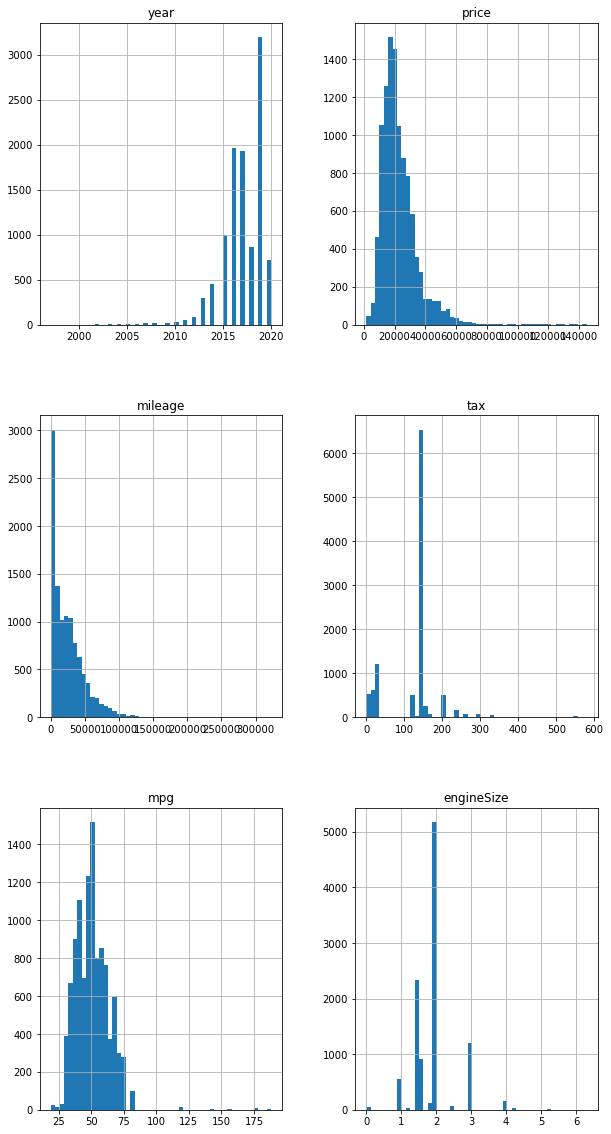

In [14]:
audi_data.hist(bins=50, figsize=(10,20)) #From histograms we can observe some trends. Almost all plots are tail heavy
#This may also indicate that we have some outliers out there, so If our score will be bad we may try to remove them.
#It also seems like after some transformations we could do some attribute to look more like normally distributed ones.
print()

## Generating Test and Training sets
Generally we should create dataset that every time we run the program will be the same and if we update our dataset with new example it is still stable.

One way to do it is to create some unique identifier that is not likely to change and then calculate a hash of it. Our sets won't change, and instances would not migrate between training and test sets.

If our dataset is big we can use purely random sampling methods, but if it is small we could not do it as we may introduce sampling bias. We must ensure that our test set somehow represents our population. Perfect tool for it is the stratified Sampling. We have to select attribute based on which we will create our stratas it's important not to have to many stratas so probably model is not the best choice. We should also select attribute that is quite important in predicting price of the car, so maybe let's start with year as it seems to be pretty important.

<AxesSubplot:>

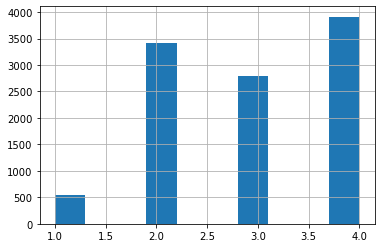

In [15]:
#We created artificial column which we will use to stratified sampling
audi_data["year_category"] = pd.cut(audi_data["year"], bins = [0, 2013, 2016, 2018, np.inf], labels=[1,2,3,4])
audi_data["year_category"].hist()


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
#This returns a generator that yields tuples with generated indices
for train_idx, test_idx in split.split(audi_data, audi_data["year_category"]):
    strat_train_set = audi_data.iloc[train_idx]
    strat_test_set = audi_data.iloc[test_idx]
    
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(audi_data, test_size=0.2,
random_state=42)



In [17]:
original = audi_data["year_category"].value_counts() / len(audi_data) # As we can see distribution is almost point on!
stratified = strat_test_set["year_category"].value_counts() / len(strat_test_set)
random = test_set["year_category"].value_counts()/ len(test_set)
pd.concat([original,stratified,random], axis=1, keys=["original", "stratified", "random"])
#Differences are about 1% in case of random sampling

,original,stratified,random
4,0.366798,0.366917,0.375820
2,0.319648,0.319588,0.318650
3,0.262373,0.262418,0.256326
1,0.051181,0.051078,0.049203


# Gaining more insights

In [18]:
#We don't need these
strat_train_set.drop("year_category",axis=1,  inplace=True)
strat_test_set.drop("year_category",axis=1,  inplace=True)

C:\Users\sebas\Miniconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
#At first lets calculate correlation matrix with our response Y since dataset is small
corr_matrix = strat_train_set.corr()
# We can see that almost all variables are linearly correlated with our response this may be a good 
#sign that linear regression should work. 
# Also all this correlations seems to be natural
# the newer the car the more expensive
# the bigger mileage the cheaper the car etc.
# As we remember in case of regression with only one predictor cor^2 = R^2
pd.concat([corr_matrix["price"], corr_matrix["price"]**2], axis=1, keys=["cor", "cor^2=R^2"])
# We now that R2 measures the proportion of variability in Y that can be explained using X and it's maximum value is 1
# So this gives a hint that predicting price based only on one variable may be very bad idea
#But this aproach works only for one variable linear regression

,cor,cor^2=R^2
year,0.589717,0.347766
price,1.000000,1.000000
mileage,-0.535912,0.287201
tax,0.353197,0.124748
mpg,-0.597766,0.357324
engineSize,0.590024,0.348128


In [23]:
# Now let's check whether we have some multicolinearity. We could inspect correlation matrix but it is better to calculate
#VIF as matrix may become big the more predictors we have
#We should remove all quantitative data
X = add_constant(strat_train_set).drop(["price" , "model", "transmission", "fuelType"], axis=1) # constant is like an intercept term
#X.columns #list of column names
#X.values data in numpy array
#variance_inflation_factor(X.values, 1) #First parameter is data, 2nd column for which we are to calculate VIF
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
#All VIFs are below 5 (apart of const but we don't care) so we don't have a problem of colinearity


const         2.313838e+06
year          2.719386e+00
mileage       2.868232e+00
tax           1.819469e+00
mpg           2.115637e+00
engineSize    1.294631e+00
dtype: float64

In [24]:
#Create a pipeline to transform our data.
#We can define our custom transformers in sklearn
from sklearn.base import BaseEstimator, TransformerMixin
class ModelTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mapping = None, model_column = 0):
        self.mapping = mapping
        self.model_column = model_column
    def fit(self, X,y=None):
        return self # we don't have to fit anything
    
    def transform(self, X,y=None):
        #We expect to get a pd Series of model names and return it mapped
        mapping = np.array([[self.mapping[x]] for x in X.values.flatten()])
        return mapping

In [25]:
model_transf = ModelTransformer(smooth_mean_mapping, 0)
model_transf.transform(strat_train_set["model"]) #Instead of models we have some ordered categories

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [26]:
#In Pipeline class we can merge a few transformers
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer #In case we have some missing values
from sklearn.pipeline import Pipeline

#We can put much more transformers here
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")) # If we have some missing values they will be filled with median of the attribute
])



In [27]:
from sklearn.compose import ColumnTransformer
#Using ColumnTransformer we can select which operations to use on which columns

num_attrs = ['year', 'mileage', 'tax', 'mpg', 'engineSize']
one_hot_attrs = ["transmission", "fuelType"]
model_attr = ["model"]

full_pipeline = ColumnTransformer([
    ("cat2", ModelTransformer(smooth_mean_mapping), model_attr),
    ("num", num_pipeline, num_attrs),
    ("cat", OneHotEncoder(), one_hot_attrs),
])


In [28]:
strat_train_x, strat_train_y = strat_train_set.drop("price", axis=1), strat_train_set["price"] 

In [29]:
strat_train_x_prepared = full_pipeline.fit_transform(strat_train_x)

# Training model and analyzing it

In [37]:
#We can use sklearn class to preform forward and backward selection
from sklearn import linear_model
from sklearn.feature_selection import SequentialFeatureSelector
#Unfortunately we can't see p-values and perform more analysis here. But for prediction this would be enough
reg = linear_model.LinearRegression()
# So we will perform forward selection and goal is to have regression not ussing all attributes
# and backward to see whether there will be differences
forward_selection = SequentialFeatureSelector(estimator = reg, n_features_to_select=strat_train_x_prepared.shape[1]-3, 
                                              direction="forward", scoring='explained_variance', cv=5 )
backward_selection = SequentialFeatureSelector(estimator = reg, n_features_to_select=strat_train_x_prepared.shape[1]-3, 
                                              direction="backward", scoring='explained_variance', cv=5 )

In [38]:
forward_selection.fit(strat_train_x_prepared, strat_train_y.values)
forward_selection.get_support() # We can see which predictors were selected

array([ True,  True,  True,  True,  True,  True, False,  True, False,
       False,  True,  True])

In [39]:
backward_selection.fit(strat_train_x_prepared, strat_train_y.values)
backward_selection.get_support() # We can see which predictors were selected
#They differ a littkle

array([ True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True, False])

## using statsmodel

In [49]:
#Just change model column to see that we can use R syntax
strat_train_statsmodel =strat_train_set.copy(deep=True)
strat_train_statsmodel['model'] = pd.Series([smooth_mean_mapping[x] for x in strat_train_statsmodel["model"]])
strat_train_statsmodel.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

In [53]:
import statsmodels.formula.api as smf

#OLS stand for ordinary least squares, and it works similarly as in R. 
# It supports DataFrame so we do not need to use any transformers
# So this is very convenient to perform linear regression fast, and perform quick analysis
result = smf.ols('price ~ model + year + transmission + mileage + fuelType + tax + mpg + engineSize', data=strat_train_statsmodel).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     2584.
Date:                Fri, 12 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:10:45   Log-Likelihood:                -68324.
No. Observations:                6830   AIC:                         1.367e+05
Df Residuals:                    6819   BIC:                         1.367e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -3.972e+06   1.21e+05    -32.939      0.000   -4.21e+06   -3.74e+06
transmission[T.Manual]    -1483.0065    202.099     -7.338      0.000   -1879.183   -1086.830
transmission[T.Semi-Auto]  -673.5532    179.736     -3.747      0.000   -1025.892    -321.214
fuelType[T.Hybrid]         3.992e+04   1560.445     25.583      0.000    3.69e+04     4.3e+04
fuelType[T.Petrol]         -471.7742    174.421     -2.705      0.007    -813.693    -129.855
model                       -61.2716    103.308     -0.593      0.553    -263.787     141.243
year                       1982.5253     59.622     33.251      0.000    1865.647    2099.403
mileage                      -0.0901      0.005    -16.953      0.000      -0.101      -0.080
tax                         -26.6656      1.445    -18.456      0.000     -29.498     -23.833
mpg                        -331.4371     10.451    -31.712      0.000    -351.925    -310.949
engineSize                  1.02e+04    152.692     66.807      0.000    9901.526    1.05e+04
==============================================================================
Omnibus:                     5638.342   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           323157.891
Skew:                           3.571   Prob(JB):                         0.00
Kurtosis:                      35.933   Cond. No.                     5.75e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.75e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
303,0.0,2018,22285,Automatic,6754,Diesel,145,52.3,1.6
1262,0.0,2017,18698,Manual,20399,Petrol,145,51.4,1.4
1343,0.0,2017,17954,Semi-Auto,21178,Petrol,150,47.9,1.4
937,0.0,2017,22998,Semi-Auto,15114,Diesel,145,62.8,2.0
136,2.0,2015,15400,Automatic,23237,Diesel,20,67.3,2.0
...,...,...,...,...,...,...,...,...,...
651,0.0,2019,36995,Automatic,11565,Diesel,145,38.2,2.0
519,0.0,2016,14995,Manual,13961,Petrol,30,58.9,1.4
2690,0.0,2014,13498,Manual,21238,Petrol,20,60.1,1.4
9010,NaN,2016,12914,Manual,45799,Diesel,20,70.6,2.0
